# Análisis Exploratorio de Datos (EDA) - Tabla: productos

## Objetivo

Realizar un análisis exploratorio completo de la tabla `productos` para:
- Explorar la estructura y contenido de los datos
- Detectar valores nulos, duplicados, atípicos e inconsistencias
- Analizar campos numéricos (precio, stock) y detectar outliers
- Identificar claves primarias y foráneas implícitas
- Analizar campos semi-estructurados
- Proponer acciones de preprocesamiento y corrección de calidad de datos
- Generar reporte de hallazgos y decisiones tomadas


## 1. Configuración Inicial e Importaciones


In [1]:
# Importar bibliotecas necesarias
import sys
import os

try:
    from ...Utils.path_manager import PathManager
except ImportError:
    # Si falla el import relativo 
    current_dir = os.getcwd()  # Directorio actual de trabajo
    if 'Notebooks' in current_dir:
        avance1_dir = os.path.dirname(os.path.dirname(current_dir))
    else:
        # Intentar calcular desde la ubicación relativa
        avance1_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
    
    utils_dir = os.path.join(avance1_dir, 'Utils')
    if utils_dir not in sys.path:
        sys.path.insert(0, utils_dir)
    from path_manager import PathManager

# Configurar sys.path usando PathManager (patrón Singleton)
path_manager = PathManager.get_instance()
path_manager.setup_sys_path()

# Importar DBConnector desde la raíz del proyecto
from Database.db_connector import DBConnector

# Importar bibliotecas de análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas correctamente")


✓ Bibliotecas importadas correctamente


In [2]:
# Obtener el Engine de la base de datos usando DBConnector (patrón Singleton)
db = DBConnector.get_instance()
engine = db.get_engine()

print("✓ Conexión a la base de datos establecida")
print(f"✓ Engine obtenido: {type(engine).__name__}")


✓ Conexión a la base de datos establecida
✓ Engine obtenido: Engine


## 2. Exploración de Estructura y Contenido con SQL


### 2.1. Estructura de la Tabla (Schema)


In [3]:
# Consulta SQL para obtener la estructura de la tabla
query_schema = """
SELECT 
    column_name,
    data_type,
    character_maximum_length,
    numeric_precision,
    numeric_scale,
    is_nullable,
    column_default
FROM information_schema.columns
WHERE table_schema = 'public' 
    AND table_name = 'productos'
ORDER BY ordinal_position;
"""

df_schema = pd.read_sql(query_schema, engine)

print("=" * 80)
print("ESTRUCTURA DE LA TABLA: productos")
print("=" * 80)
print(df_schema.to_string(index=False))


ESTRUCTURA DE LA TABLA: productos
 column_name         data_type  character_maximum_length  numeric_precision  numeric_scale is_nullable                                 column_default
 producto_id           integer                       NaN               32.0            0.0          NO nextval('productos_producto_id_seq'::regclass)
      nombre character varying                     255.0                NaN            NaN          NO                                           None
 descripcion character varying                       NaN                NaN            NaN         YES                                           None
      precio           numeric                       NaN               10.0            2.0          NO                                           None
       stock           integer                       NaN               32.0            0.0          NO                                           None
categoria_id           integer                       NaN          

### 2.2. Restricciones y Claves (Constraints)


In [4]:
# Consulta SQL para obtener restricciones de la tabla
query_constraints = """
SELECT
    tc.constraint_name,
    tc.constraint_type,
    kcu.column_name,
    ccu.table_name AS foreign_table_name,
    ccu.column_name AS foreign_column_name
FROM information_schema.table_constraints AS tc
JOIN information_schema.key_column_usage AS kcu
    ON tc.constraint_name = kcu.constraint_name
    AND tc.table_schema = kcu.table_schema
LEFT JOIN information_schema.constraint_column_usage AS ccu
    ON ccu.constraint_name = tc.constraint_name
    AND ccu.table_schema = tc.table_schema
WHERE tc.table_schema = 'public'
    AND tc.table_name = 'productos'
ORDER BY tc.constraint_type, tc.constraint_name;
"""

df_constraints = pd.read_sql(query_constraints, engine)

print("=" * 80)
print("RESTRICCIONES Y CLAVES DE LA TABLA: productos")
print("=" * 80)
if not df_constraints.empty:
    print(df_constraints.to_string(index=False))
else:
    print("No se encontraron restricciones explícitas.")

# Consulta adicional para obtener CheckConstraints
query_checks = """
SELECT
    conname AS constraint_name,
    pg_get_constraintdef(oid) AS constraint_definition
FROM pg_constraint
WHERE conrelid = 'public.productos'::regclass
    AND contype = 'c';
"""

df_checks = pd.read_sql(query_checks, engine)

if not df_checks.empty:
    print("\n" + "=" * 80)
    print("CHECK CONSTRAINTS")
    print("=" * 80)
    print(df_checks.to_string(index=False))


RESTRICCIONES Y CLAVES DE LA TABLA: productos
            constraint_name constraint_type  column_name foreign_table_name foreign_column_name
productos_categoria_id_fkey     FOREIGN KEY categoria_id         categorias        categoria_id
             productos_pkey     PRIMARY KEY  producto_id          productos         producto_id

CHECK CONSTRAINTS
      constraint_name            constraint_definition
check_precio_positivo CHECK ((precio >= (0)::numeric))
 check_stock_positivo             CHECK ((stock >= 0))


In [5]:
# Consultas SQL para estadísticas básicas
query_stats = """
SELECT 
    COUNT(*) as total_registros,
    COUNT(DISTINCT producto_id) as productos_unicos,
    COUNT(DISTINCT nombre) as nombres_unicos,
    COUNT(DISTINCT categoria_id) as categorias_distintas,
    COUNT(descripcion) as descripciones_no_nulas,
    COUNT(*) - COUNT(descripcion) as descripciones_nulas,
    MIN(precio) as precio_minimo,
    MAX(precio) as precio_maximo,
    AVG(precio) as precio_promedio,
    MIN(stock) as stock_minimo,
    MAX(stock) as stock_maximo,
    AVG(stock) as stock_promedio,
    SUM(stock) as stock_total
FROM productos;
"""

df_stats = pd.read_sql(query_stats, engine)

print("=" * 80)
print("ESTADÍSTICAS BÁSICAS DE LA TABLA: productos")
print("=" * 80)
print(df_stats.to_string(index=False))


ESTADÍSTICAS BÁSICAS DE LA TABLA: productos
 total_registros  productos_unicos  nombres_unicos  categorias_distintas  descripciones_no_nulas  descripciones_nulas  precio_minimo  precio_maximo  precio_promedio  stock_minimo  stock_maximo  stock_promedio  stock_total
              36                36              36                    12                      36                    0            4.5          799.0        86.083611            20           300       87.777778         3160


## 3. Análisis Exploratorio con Python (SQLAlchemy)


In [6]:
# Cargar la tabla completa en un DataFrame
query_productos = "SELECT * FROM productos;"
df_productos = pd.read_sql(query_productos, engine)

print("=" * 80)
print("CARGA DE DATOS COMPLETA")
print("=" * 80)
print(f"Forma del DataFrame: {df_productos.shape}")
print(f"Columnas: {list(df_productos.columns)}")
print(f"\nPrimeras 10 filas:")
print(df_productos.head(10))


CARGA DE DATOS COMPLETA
Forma del DataFrame: (36, 6)
Columnas: ['producto_id', 'nombre', 'descripcion', 'precio', 'stock', 'categoria_id']

Primeras 10 filas:
   producto_id                      nombre  \
0            1       Smartphone Galaxy A54   
1            2     Laptop Dell Inspiron 15   
2            3  Auriculares Bluetooth Sony   
3            4      Camiseta Básica Hombre   
4            5          Jeans Skinny Mujer   
5            6       Zapatillas Deportivas   
6            7   Sartén Antiadherente 24cm   
7            8      Juego de Sábanas Queen   
8            9   Lámpara de Escritorio LED   
9           10    Bicicleta Montaña Aro 29   

                                         descripcion  precio  stock  \
0  Teléfono inteligente con pantalla AMOLED y cám...  349.99     50   
1  Laptop para trabajo y estudio con procesador I...  799.00     30   
2  Auriculares inalámbricos con cancelación de ru...  129.99    100   
3  Camiseta de algodón 100% disponible en varias .

### 3.1. Información General del DataFrame


In [7]:
# Información detallada del DataFrame
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATAFRAME")
print("=" * 80)
df_productos.info()
print("\n" + "=" * 80)
print("TIPOS DE DATOS POR COLUMNA")
print("=" * 80)
print(df_productos.dtypes)
print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 80)
print(df_productos.describe(include='all'))


INFORMACIÓN GENERAL DEL DATAFRAME
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   producto_id   36 non-null     int64  
 1   nombre        36 non-null     object 
 2   descripcion   36 non-null     object 
 3   precio        36 non-null     float64
 4   stock         36 non-null     int64  
 5   categoria_id  36 non-null     int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.8+ KB

TIPOS DE DATOS POR COLUMNA
producto_id       int64
nombre           object
descripcion      object
precio          float64
stock             int64
categoria_id      int64
dtype: object

ESTADÍSTICAS DESCRIPTIVAS
        producto_id                 nombre  \
count     36.000000                     36   
unique          NaN                     36   
top             NaN  Smartphone Galaxy A54   
freq            NaN                      1   
mean      18.50

### 3.2. Detección de Valores Nulos


In [8]:
# Análisis de valores nulos
print("=" * 80)
print("ANÁLISIS DE VALORES NULOS")
print("=" * 80)

nulos_por_columna = df_productos.isnull().sum()
porcentaje_nulos = (df_productos.isnull().sum() / len(df_productos)) * 100

df_nulos = pd.DataFrame({
    'Columna': nulos_por_columna.index,
    'Cantidad_Nulos': nulos_por_columna.values,
    'Porcentaje_Nulos': porcentaje_nulos.values
})

print(df_nulos.to_string(index=False))

# Verificar si hay valores nulos en total
total_nulos = df_productos.isnull().sum().sum()
print(f"\nTotal de valores nulos en toda la tabla: {total_nulos}")

if total_nulos == 0:
    print("✓ No se encontraron valores nulos en la tabla.")
else:
    print("⚠ ADVERTENCIA: Se encontraron valores nulos que requieren atención.")
    print("\nAnálisis de valores nulos por columna:")
    for col in df_productos.columns:
        nulos_col = df_productos[col].isnull().sum()
        if nulos_col > 0:
            print(f"  - {col}: {nulos_col} valores nulos ({nulos_col/len(df_productos)*100:.1f}%)")


ANÁLISIS DE VALORES NULOS
     Columna  Cantidad_Nulos  Porcentaje_Nulos
 producto_id               0               0.0
      nombre               0               0.0
 descripcion               0               0.0
      precio               0               0.0
       stock               0               0.0
categoria_id               0               0.0

Total de valores nulos en toda la tabla: 0
✓ No se encontraron valores nulos en la tabla.


### 3.3. Detección de Duplicados


In [9]:
# Análisis de duplicados
print("=" * 80)
print("ANÁLISIS DE DUPLICADOS")
print("=" * 80)

# Duplicados completos (todas las columnas)
duplicados_completos = df_productos.duplicated().sum()
print(f"Registros completamente duplicados: {duplicados_completos}")

# Duplicados por producto_id (clave primaria)
duplicados_producto_id = df_productos['producto_id'].duplicated().sum()
print(f"Duplicados en producto_id (PK): {duplicados_producto_id}")

# Duplicados por nombre (puede haber nombres duplicados si no hay restricción UNIQUE)
duplicados_nombre = df_productos['nombre'].duplicated().sum()
print(f"Duplicados en nombre: {duplicados_nombre}")

# Mostrar duplicados si existen
if duplicados_completos > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron registros completamente duplicados:")
    duplicados = df_productos[df_productos.duplicated(keep=False)]
    print(duplicados.sort_values('producto_id'))

if duplicados_nombre > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron nombres de productos duplicados:")
    nombres_duplicados = df_productos[df_productos['nombre'].duplicated(keep=False)]
    print(nombres_duplicados[['producto_id', 'nombre', 'precio', 'categoria_id']].sort_values('nombre'))

if duplicados_completos == 0 and duplicados_producto_id == 0:
    print("\n✓ No se encontraron duplicados en la tabla.")
    if duplicados_nombre > 0:
        print("  Nota: Hay nombres duplicados pero esto puede ser intencional si no hay restricción UNIQUE.")


ANÁLISIS DE DUPLICADOS
Registros completamente duplicados: 0
Duplicados en producto_id (PK): 0
Duplicados en nombre: 0

✓ No se encontraron duplicados en la tabla.


### 3.4. Análisis de Campos Numéricos (Precio y Stock)


In [10]:
# Análisis de campos numéricos
print("=" * 80)
print("ANÁLISIS DE CAMPOS NUMÉRICOS")
print("=" * 80)

campos_numericos = ['precio', 'stock']

for campo in campos_numericos:
    print(f"\n--- Análisis de '{campo}' ---")
    valores = df_productos[campo]
    
    print(f"Estadísticas descriptivas:")
    print(f"  Mínimo: {valores.min()}")
    print(f"  Máximo: {valores.max()}")
    print(f"  Media: {valores.mean():.2f}")
    print(f"  Mediana: {valores.median():.2f}")
    print(f"  Desviación estándar: {valores.std():.2f}")
    print(f"  Q1 (25%): {valores.quantile(0.25):.2f}")
    print(f"  Q3 (75%): {valores.quantile(0.75):.2f}")
    print(f"  IQR: {valores.quantile(0.75) - valores.quantile(0.25):.2f}")
    
    # Valores negativos (violan constraint)
    valores_negativos = df_productos[df_productos[campo] < 0]
    if len(valores_negativos) > 0:
        print(f"  ⚠ Valores negativos (violan constraint): {len(valores_negativos)}")
        print(valores_negativos[['producto_id', 'nombre', campo]])
    else:
        print(f"  ✓ No hay valores negativos")
    
    # Valores cero
    valores_cero = df_productos[df_productos[campo] == 0]
    if len(valores_cero) > 0:
        print(f"  - Valores iguales a cero: {len(valores_cero)}")
        if campo == 'precio':
            print(f"    ⚠ Productos con precio cero pueden ser problemáticos")
        elif campo == 'stock':
            print(f"    - Productos sin stock (agotados)")
    
    # Detección de outliers usando IQR
    Q1 = valores.quantile(0.25)
    Q3 = valores.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    outliers = df_productos[(df_productos[campo] < limite_inferior) | (df_productos[campo] > limite_superior)]
    if len(outliers) > 0:
        print(f"  ⚠ Valores atípicos (outliers) detectados: {len(outliers)}")
        print(f"    Límite inferior: {limite_inferior:.2f}")
        print(f"    Límite superior: {limite_superior:.2f}")
        print(f"    Ejemplos de outliers:")
        print(outliers[['producto_id', 'nombre', campo]].head(5))
    else:
        print(f"  ✓ No se detectaron outliers significativos")


ANÁLISIS DE CAMPOS NUMÉRICOS

--- Análisis de 'precio' ---
Estadísticas descriptivas:
  Mínimo: 4.5
  Máximo: 799.0
  Media: 86.08
  Mediana: 30.99
  Desviación estándar: 164.25
  Q1 (25%): 19.47
  Q3 (75%): 56.25
  IQR: 36.78
  ✓ No hay valores negativos
  ⚠ Valores atípicos (outliers) detectados: 5
    Límite inferior: -35.70
    Límite superior: 111.42
    Ejemplos de outliers:
    producto_id                      nombre  precio
0             1       Smartphone Galaxy A54  349.99
1             2     Laptop Dell Inspiron 15  799.00
2             3  Auriculares Bluetooth Sony  129.99
9            10    Bicicleta Montaña Aro 29  299.00
33           34       Consola PlayStation 5  549.99

--- Análisis de 'stock' ---
Estadísticas descriptivas:
  Mínimo: 20
  Máximo: 300
  Media: 87.78
  Mediana: 77.50
  Desviación estándar: 58.45
  Q1 (25%): 50.00
  Q3 (75%): 102.50
  IQR: 52.50
  ✓ No hay valores negativos
  ⚠ Valores atípicos (outliers) detectados: 3
    Límite inferior: -28.75
    Lím

### 3.5. Análisis de Campos de Texto


In [11]:
# Análisis de campos de texto
print("=" * 80)
print("ANÁLISIS DE CAMPOS DE TEXTO")
print("=" * 80)

campos_texto = ['nombre', 'descripcion']

for campo in campos_texto:
    print(f"\n--- Análisis de '{campo}' ---")
    
    # Filtrar valores no nulos para análisis
    valores_no_nulos = df_productos[campo].dropna()
    
    if len(valores_no_nulos) > 0:
        print(f"Valores no nulos: {len(valores_no_nulos)}")
        print(f"Longitud mínima: {valores_no_nulos.str.len().min()}")
        print(f"Longitud máxima: {valores_no_nulos.str.len().max()}")
        print(f"Longitud promedio: {valores_no_nulos.str.len().mean():.2f}")
        print(f"Valores únicos: {valores_no_nulos.nunique()}")
        
        # Valores vacíos o solo espacios
        valores_vacios = (valores_no_nulos.str.strip() == '').sum()
        if valores_vacios > 0:
            print(f"⚠ Valores vacíos o solo espacios: {valores_vacios}")
        
        # Mostrar algunos ejemplos
        print(f"Ejemplos (primeros 5):")
        print(valores_no_nulos.head().tolist())
        
        # Análisis de palabras únicas (solo para descripción)
        if campo == 'descripcion':
            todas_palabras = ' '.join(valores_no_nulos.astype(str)).lower()
            palabras_unicas = len(set(re.findall(r'\b\w+\b', todas_palabras)))
            print(f"Palabras únicas en descripciones: {palabras_unicas}")
    else:
        print(f"⚠ Todos los valores son nulos para este campo")


ANÁLISIS DE CAMPOS DE TEXTO

--- Análisis de 'nombre' ---
Valores no nulos: 36
Longitud mínima: 17
Longitud máxima: 30
Longitud promedio: 22.33
Valores únicos: 36
Ejemplos (primeros 5):
['Smartphone Galaxy A54', 'Laptop Dell Inspiron 15', 'Auriculares Bluetooth Sony', 'Camiseta Básica Hombre', 'Jeans Skinny Mujer']

--- Análisis de 'descripcion' ---
Valores no nulos: 36
Longitud mínima: 27
Longitud máxima: 57
Longitud promedio: 40.94
Valores únicos: 36
Ejemplos (primeros 5):
['Teléfono inteligente con pantalla AMOLED y cámara triple.', 'Laptop para trabajo y estudio con procesador Intel i5.', 'Auriculares inalámbricos con cancelación de ruido.', 'Camiseta de algodón 100% disponible en varias tallas.', 'Jeans corte skinny de mezclilla azul.']
Palabras únicas en descripciones: 154


### 3.6. Análisis de Relación con Categorías


In [12]:
# Análisis de relación con categorías
print("=" * 80)
print("ANÁLISIS DE RELACIÓN CON CATEGORÍAS")
print("=" * 80)

# Verificar valores nulos en categoria_id
categoria_id_nulos = df_productos['categoria_id'].isnull().sum()
print(f"Productos con categoria_id nulo: {categoria_id_nulos}")

if categoria_id_nulos > 0:
    print("⚠ ADVERTENCIA: Productos sin categoría asignada:")
    print(df_productos[df_productos['categoria_id'].isnull()][['producto_id', 'nombre', 'precio']])

# Distribución de productos por categoría
print("\nDistribución de productos por categoría:")
distribucion_categoria = df_productos['categoria_id'].value_counts().sort_index()
print(distribucion_categoria)

# Obtener nombres de categorías
query_categorias = """
SELECT c.categoria_id, c.nombre as categoria_nombre, COUNT(p.producto_id) as cantidad_productos
FROM categorias c
LEFT JOIN productos p ON c.categoria_id = p.categoria_id
GROUP BY c.categoria_id, c.nombre
ORDER BY cantidad_productos DESC;
"""

df_categorias_productos = pd.read_sql(query_categorias, engine)

print("\n" + "=" * 80)
print("PRODUCTOS POR CATEGORÍA (con nombres)")
print("=" * 80)
print(df_categorias_productos.to_string(index=False))

# Verificar referencias huérfanas (categoria_id que no existe en categorias)
query_orphan = """
SELECT COUNT(*) as huérfanas
FROM productos p
LEFT JOIN categorias c ON p.categoria_id = c.categoria_id
WHERE p.categoria_id IS NOT NULL AND c.categoria_id IS NULL;
"""

df_orphan = pd.read_sql(query_orphan, engine)
huérfanas = df_orphan['huérfanas'].iloc[0]

if huérfanas > 0:
    print(f"\n⚠ ADVERTENCIA: Se encontraron {huérfanas} referencias huérfanas (categoria_id que no existe en categorias)")
    query_orphan_detalle = """
    SELECT p.producto_id, p.nombre, p.categoria_id
    FROM productos p
    LEFT JOIN categorias c ON p.categoria_id = c.categoria_id
    WHERE p.categoria_id IS NOT NULL AND c.categoria_id IS NULL;
    """
    df_orphan_detalle = pd.read_sql(query_orphan_detalle, engine)
    print(df_orphan_detalle)
else:
    print("\n✓ No se encontraron referencias huérfanas.")


ANÁLISIS DE RELACIÓN CON CATEGORÍAS
Productos con categoria_id nulo: 0

Distribución de productos por categoría:
categoria_id
1     3
2     3
3     3
4     3
5     3
6     3
7     3
8     3
9     3
10    3
11    3
12    3
Name: count, dtype: int64

PRODUCTOS POR CATEGORÍA (con nombres)
 categoria_id           categoria_nombre  cantidad_productos
            4      Deportes y Aire Libre                   3
           10                   Mascotas                   3
            6          Juguetes y Juegos                   3
            2                       Moda                   3
           11       Tecnología y Gadgets                   3
            9                      Salud                   3
            7                 Automotriz                   3
           12                Videojuegos                   3
            3             Hogar y Cocina                   3
            1                Electrónica                   3
            5 Belleza y Cuidado Personal  

### 3.7. Detección de Valores Atípicos y Anomalías


In [13]:
# Detección de valores atípicos y anomalías
print("=" * 80)
print("DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS")
print("=" * 80)

anomalias = []

# 1. Precios muy altos o muy bajos
precio_promedio = df_productos['precio'].mean()
precio_std = df_productos['precio'].std()
precios_muy_altos = df_productos[df_productos['precio'] > precio_promedio + 3 * precio_std]
precios_muy_bajos = df_productos[df_productos['precio'] < precio_promedio - 3 * precio_std]

if len(precios_muy_altos) > 0:
    print(f"⚠ Precios muy altos (> media + 3*std): {len(precios_muy_altos)}")
    anomalias.append(('Precios muy altos', len(precios_muy_altos)))
    print(precios_muy_altos[['producto_id', 'nombre', 'precio', 'categoria_id']])

if len(precios_muy_bajos) > 0:
    print(f"⚠ Precios muy bajos (< media - 3*std): {len(precios_muy_bajos)}")
    anomalias.append(('Precios muy bajos', len(precios_muy_bajos)))
    print(precios_muy_bajos[['producto_id', 'nombre', 'precio', 'categoria_id']])

# 2. Stock muy alto o muy bajo
stock_promedio = df_productos['stock'].mean()
stock_std = df_productos['stock'].std()
stock_muy_alto = df_productos[df_productos['stock'] > stock_promedio + 3 * stock_std]
stock_muy_bajo = df_productos[df_productos['stock'] < stock_promedio - 3 * stock_std]

if len(stock_muy_alto) > 0:
    print(f"\n⚠ Stock muy alto (> media + 3*std): {len(stock_muy_alto)}")
    anomalias.append(('Stock muy alto', len(stock_muy_alto)))
    print(stock_muy_alto[['producto_id', 'nombre', 'stock', 'categoria_id']])

if len(stock_muy_bajo) > 0:
    print(f"\n⚠ Stock muy bajo (< media - 3*std): {len(stock_muy_bajo)}")
    anomalias.append(('Stock muy bajo', len(stock_muy_bajo)))
    print(stock_muy_bajo[['producto_id', 'nombre', 'stock', 'categoria_id']])

# 3. Productos con precio cero
productos_precio_cero = df_productos[df_productos['precio'] == 0]
if len(productos_precio_cero) > 0:
    print(f"\n⚠ Productos con precio cero: {len(productos_precio_cero)}")
    anomalias.append(('Precio cero', len(productos_precio_cero)))
    print(productos_precio_cero[['producto_id', 'nombre', 'precio', 'stock']])

# 4. Nombres muy cortos o muy largos
nombres_cortos = df_productos[df_productos['nombre'].str.len() < 3]
nombres_largos = df_productos[df_productos['nombre'].str.len() > 255]

if len(nombres_cortos) > 0:
    print(f"\n⚠ Nombres muy cortos (< 3 caracteres): {len(nombres_cortos)}")
    anomalias.append(('Nombres muy cortos', len(nombres_cortos)))
    print(nombres_cortos[['producto_id', 'nombre']])

if len(nombres_largos) > 0:
    print(f"\n⚠ Nombres muy largos (> 255 caracteres): {len(nombres_largos)}")
    anomalias.append(('Nombres muy largos', len(nombres_largos)))
    print(nombres_largos[['producto_id', 'nombre']])

# 5. Productos sin categoría
productos_sin_categoria = df_productos[df_productos['categoria_id'].isnull()]
if len(productos_sin_categoria) > 0:
    print(f"\n⚠ Productos sin categoría asignada: {len(productos_sin_categoria)}")
    anomalias.append(('Sin categoría', len(productos_sin_categoria)))
    print(productos_sin_categoria[['producto_id', 'nombre', 'precio']])

# Resumen de anomalías
if len(anomalias) == 0:
    print("\n✓ No se detectaron anomalías significativas.")
else:
    print("\n" + "=" * 80)
    print("RESUMEN DE ANOMALÍAS DETECTADAS")
    print("=" * 80)
    df_anomalias = pd.DataFrame(anomalias, columns=['Tipo de Anomalía', 'Cantidad'])
    print(df_anomalias.to_string(index=False))


DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS
⚠ Precios muy altos (> media + 3*std): 1
   producto_id                   nombre  precio  categoria_id
1            2  Laptop Dell Inspiron 15   799.0             1

⚠ Stock muy alto (> media + 3*std): 1
    producto_id                       nombre  stock  categoria_id
22           23  Cuaderno Universitario 100h    300             8

RESUMEN DE ANOMALÍAS DETECTADAS
 Tipo de Anomalía  Cantidad
Precios muy altos         1
   Stock muy alto         1


In [14]:
# Identificación de claves primarias y foráneas
print("=" * 80)
print("IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS")
print("=" * 80)

# Clave primaria explícita
print("\n1. CLAVE PRIMARIA:")
print("   - producto_id: PRIMARY KEY, AUTO_INCREMENT")
print(f"   - Rango de valores: {df_productos['producto_id'].min()} a {df_productos['producto_id'].max()}")
print(f"   - Valores únicos: {df_productos['producto_id'].nunique()}")
print(f"   - Total de registros: {len(df_productos)}")
print(f"   - ¿Sin duplicados?: {df_productos['producto_id'].nunique() == len(df_productos)}")

# Verificar si hay gaps en la secuencia
ids_ordenados = sorted(df_productos['producto_id'].tolist())
gaps = []
for i in range(len(ids_ordenados) - 1):
    if ids_ordenados[i+1] - ids_ordenados[i] > 1:
        gaps.append((ids_ordenados[i], ids_ordenados[i+1]))
if gaps:
    print(f"   ⚠ Se encontraron gaps en la secuencia: {len(gaps)} gaps")
else:
    print(f"   ✓ La secuencia de IDs es continua")

# Clave foránea
print("\n2. CLAVE FORÁNEA:")
print("   - categoria_id: FOREIGN KEY → categorias.categoria_id")
categoria_id_nulos = df_productos['categoria_id'].isnull().sum()
print(f"   - Valores nulos: {categoria_id_nulos}")
print(f"   - Categorías distintas: {df_productos['categoria_id'].nunique()}")

# Claves foráneas que referencian esta tabla
print("\n3. CLAVES FORÁNEAS QUE REFERENCIAN ESTA TABLA:")
print("   (Verificar en otras tablas)")

tablas_relacionadas = ['detalle_ordenes', 'carrito', 'resenas_productos']
for tabla in tablas_relacionadas:
    try:
        query_fk = f"""
        SELECT COUNT(*) as total
        FROM {tabla}
        WHERE producto_id IS NOT NULL;
        """
        df_fk = pd.read_sql(query_fk, engine)
        total_refs = df_fk['total'].iloc[0]
        
        # Verificar referencias huérfanas
        query_orphan = f"""
        SELECT COUNT(*) as huérfanas
        FROM {tabla} t
        LEFT JOIN productos p ON t.producto_id = p.producto_id
        WHERE t.producto_id IS NOT NULL AND p.producto_id IS NULL;
        """
        df_orphan = pd.read_sql(query_orphan, engine)
        huérfanas = df_orphan['huérfanas'].iloc[0]
        
        # Verificar productos sin referencias
        query_sin_refs = f"""
        SELECT p.producto_id, p.nombre
        FROM productos p
        LEFT JOIN {tabla} t ON p.producto_id = t.producto_id
        WHERE t.producto_id IS NULL
        ORDER BY p.producto_id
        LIMIT 10;
        """
        df_sin_refs = pd.read_sql(query_sin_refs, engine)
        
        print(f"   - {tabla}.producto_id: {total_refs} referencias")
        if huérfanas > 0:
            print(f"     ⚠ Referencias huérfanas: {huérfanas}")
        if len(df_sin_refs) > 0:
            print(f"     - Productos sin referencias en {tabla}: {len(df_sin_refs)} (mostrando primeros 10)")
    except Exception as e:
        print(f"   - {tabla}: No se pudo verificar ({str(e)})")


IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS

1. CLAVE PRIMARIA:
   - producto_id: PRIMARY KEY, AUTO_INCREMENT
   - Rango de valores: 1 a 36
   - Valores únicos: 36
   - Total de registros: 36
   - ¿Sin duplicados?: True
   ✓ La secuencia de IDs es continua

2. CLAVE FORÁNEA:
   - categoria_id: FOREIGN KEY → categorias.categoria_id
   - Valores nulos: 0
   - Categorías distintas: 12

3. CLAVES FORÁNEAS QUE REFERENCIAN ESTA TABLA:
   (Verificar en otras tablas)
   - detalle_ordenes.producto_id: 10000 referencias
   - carrito.producto_id: 5000 referencias
   - resenas_productos.producto_id: 6474 referencias


## 5. Análisis de Campos Semi-Estructurados


In [15]:
# Análisis de campos semi-estructurados
print("=" * 80)
print("ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS")
print("=" * 80)

# Verificar si hay campos JSON, listas o concatenaciones delimitadas
campos_analizar = ['nombre', 'descripcion']

print("\nBúsqueda de campos que puedan contener datos semi-estructurados:\n")

# 1. Buscar campos que contengan JSON
print("1. Campos con formato JSON:")
json_encontrado = False
for campo in campos_analizar:
    valores_no_nulos = df_productos[campo].dropna()
    if len(valores_no_nulos) > 0:
        json_pattern = r'\{.*\}|\[.*\]'
        tiene_json = valores_no_nulos.str.contains(json_pattern, na=False, regex=True).sum()
        if tiene_json > 0:
            print(f"   ⚠ {campo}: {tiene_json} registros con posible formato JSON")
            json_encontrado = True
            # Mostrar ejemplos
            ejemplos = valores_no_nulos[valores_no_nulos.str.contains(json_pattern, na=False, regex=True)].head(3)
            for ejemplo in ejemplos:
                print(f"      Ejemplo: {ejemplo[:150]}...")
if not json_encontrado:
    print("   ✓ No se encontraron campos con formato JSON")

# 2. Buscar campos con delimitadores comunes (listas)
print("\n2. Campos con delimitadores (listas):")
delimitadores = [',', ';', '|', '||']
delimitadores_encontrados = False
for campo in campos_analizar:
    valores_no_nulos = df_productos[campo].dropna()
    if len(valores_no_nulos) > 0:
        for delim in delimitadores:
            tiene_delim = valores_no_nulos.str.contains(delim, na=False, regex=False).sum()
            if tiene_delim > 0:
                print(f"   ⚠ {campo}: {tiene_delim} registros con delimitador '{delim}'")
                delimitadores_encontrados = True
                # Mostrar ejemplos
                ejemplos = valores_no_nulos[valores_no_nulos.str.contains(delim, na=False, regex=False)].head(3)
                for ejemplo in ejemplos:
                    print(f"      Ejemplo: {ejemplo[:100]}...")
if not delimitadores_encontrados:
    print("   ✓ No se encontraron campos con delimitadores estructurados")

# 3. Análisis de descripciones con múltiples valores
print("\n3. Análisis de estructura de descripciones:")
descripciones_no_nulas = df_productos['descripcion'].dropna()
if len(descripciones_no_nulas) > 0:
    # Verificar si las descripciones contienen listas separadas por comas
    descripciones_con_listas = descripciones_no_nulas[descripciones_no_nulas.str.contains(r',\s*\w+', na=False, regex=True)]
    if len(descripciones_con_listas) > 0:
        print(f"   - Descripciones que parecen contener listas: {len(descripciones_con_listas)}")
        print(f"     Ejemplos:")
        for ejemplo in descripciones_con_listas.head(3):
            print(f"      - {ejemplo[:150]}...")
    else:
        print("   ✓ Las descripciones no parecen contener listas estructuradas")

print("\n" + "=" * 80)
print("CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:")
print("=" * 80)
print("La tabla 'productos' no contiene campos explícitamente semi-estructurados (JSON, listas).")
print("Las descripciones pueden contener texto con comas, pero esto es parte del contenido")
print("textual normal y no requiere transformación adicional.")


ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS

Búsqueda de campos que puedan contener datos semi-estructurados:

1. Campos con formato JSON:
   ✓ No se encontraron campos con formato JSON

2. Campos con delimitadores (listas):
   ⚠ nombre: 1 registros con delimitador ','
      Ejemplo: Power Bank 20,000mAh...
   ⚠ descripcion: 2 registros con delimitador ','
      Ejemplo: Cuaderno rayado, tamaño A4....
      Ejemplo: Vitaminas para adultos, frasco de 60 tabletas....

3. Análisis de estructura de descripciones:
   - Descripciones que parecen contener listas: 2
     Ejemplos:
      - Cuaderno rayado, tamaño A4....
      - Vitaminas para adultos, frasco de 60 tabletas....

CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:
La tabla 'productos' no contiene campos explícitamente semi-estructurados (JSON, listas).
Las descripciones pueden contener texto con comas, pero esto es parte del contenido
textual normal y no requiere transformación adicional.


## 6. Visualizaciones


GENERANDO VISUALIZACIONES


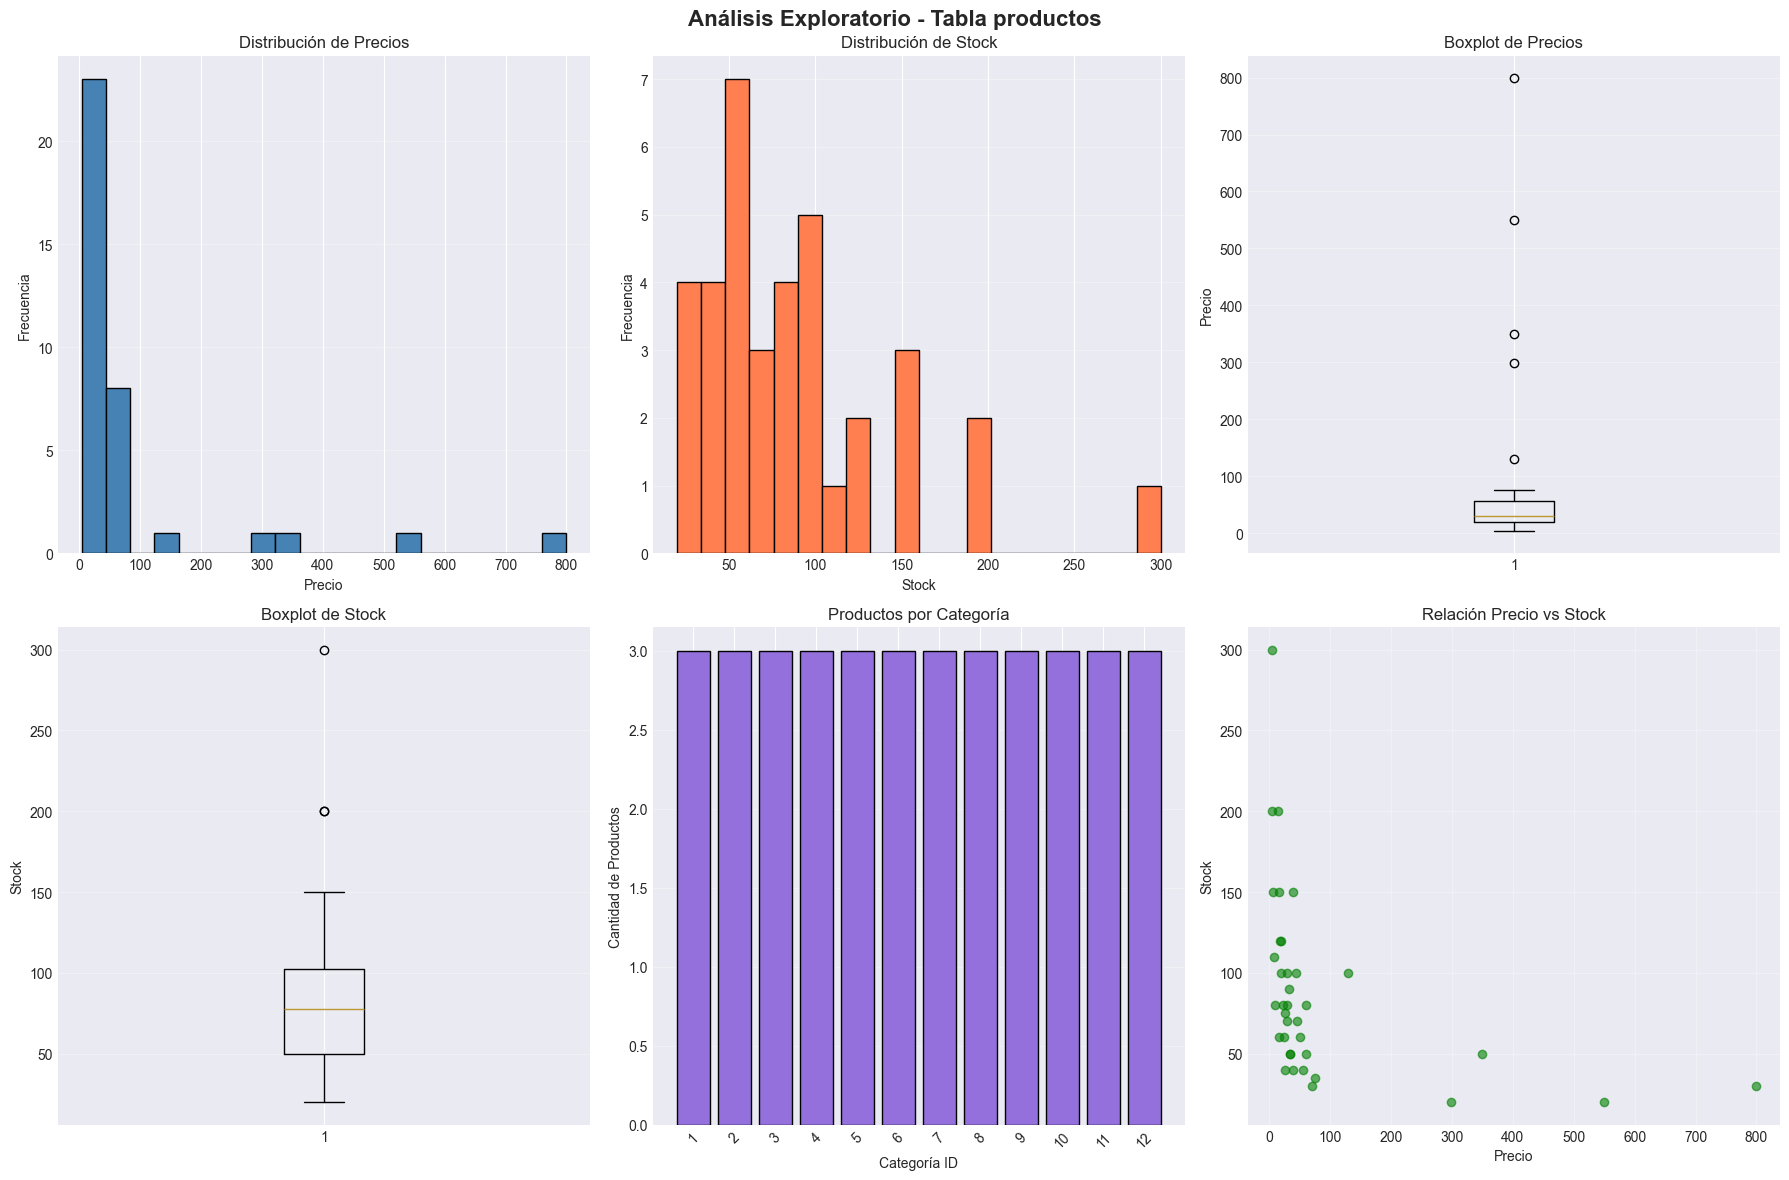

✓ Visualizaciones generadas correctamente


In [16]:
# Visualizaciones
print("=" * 80)
print("GENERANDO VISUALIZACIONES")
print("=" * 80)

# Configurar el tamaño de las figuras
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis Exploratorio - Tabla productos', fontsize=16, fontweight='bold')

# 1. Distribución de precios
ax1 = axes[0, 0]
ax1.hist(df_productos['precio'], bins=20, color='steelblue', edgecolor='black')
ax1.set_title('Distribución de Precios')
ax1.set_xlabel('Precio')
ax1.set_ylabel('Frecuencia')
ax1.grid(axis='y', alpha=0.3)

# 2. Distribución de stock
ax2 = axes[0, 1]
ax2.hist(df_productos['stock'], bins=20, color='coral', edgecolor='black')
ax2.set_title('Distribución de Stock')
ax2.set_xlabel('Stock')
ax2.set_ylabel('Frecuencia')
ax2.grid(axis='y', alpha=0.3)

# 3. Boxplot de precios
ax3 = axes[0, 2]
ax3.boxplot(df_productos['precio'], vert=True)
ax3.set_title('Boxplot de Precios')
ax3.set_ylabel('Precio')
ax3.grid(axis='y', alpha=0.3)

# 4. Boxplot de stock
ax4 = axes[1, 0]
ax4.boxplot(df_productos['stock'], vert=True)
ax4.set_title('Boxplot de Stock')
ax4.set_ylabel('Stock')
ax4.grid(axis='y', alpha=0.3)

# 5. Productos por categoría
ax5 = axes[1, 1]
distribucion_categoria = df_productos['categoria_id'].value_counts().sort_index()
ax5.bar(range(len(distribucion_categoria)), distribucion_categoria.values, color='mediumpurple', edgecolor='black')
ax5.set_title('Productos por Categoría')
ax5.set_xlabel('Categoría ID')
ax5.set_ylabel('Cantidad de Productos')
ax5.set_xticks(range(len(distribucion_categoria)))
ax5.set_xticklabels(distribucion_categoria.index, rotation=45)
ax5.grid(axis='y', alpha=0.3)

# 6. Relación Precio vs Stock
ax6 = axes[1, 2]
ax6.scatter(df_productos['precio'], df_productos['stock'], alpha=0.6, color='green')
ax6.set_title('Relación Precio vs Stock')
ax6.set_xlabel('Precio')
ax6.set_ylabel('Stock')
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizaciones generadas correctamente")


## 7. Reporte de Hallazgos y Decisiones


### 7.1. Principales Insights y Problemas Encontrados


In [17]:
# Generar reporte de hallazgos
print("=" * 80)
print("REPORTE DE HALLAZGOS - TABLA: productos")
print("=" * 80)

hallazgos = []

# 1. Calidad general de datos
print("\n1. CALIDAD GENERAL DE DATOS:")
print("   ✓ Total de registros:", len(df_productos))
print("   ✓ Valores nulos:", df_productos.isnull().sum().sum())
print("   ✓ Duplicados completos:", df_productos.duplicated().sum())
print("   ✓ Integridad de clave primaria:", "OK" if df_productos['producto_id'].nunique() == len(df_productos) else "ERROR")

hallazgos.append({
    'Categoría': 'Calidad General',
    'Hallazgo': f'Tabla con {len(df_productos)} registros. Integridad de clave primaria correcta.',
    'Severidad': 'Baja',
    'Estado': 'OK'
})

# 2. Problemas detectados
print("\n2. PROBLEMAS DETECTADOS:")

problemas = []

# Valores nulos en descripción
nulos_descripcion = df_productos['descripcion'].isnull().sum()
if nulos_descripcion > 0:
    problemas.append({
        'Categoría': 'Valores Nulos',
        'Problema': f'Descripciones nulas: {nulos_descripcion} ({nulos_descripcion/len(df_productos)*100:.1f}%)',
        'Severidad': 'Baja',
        'Acción Requerida': 'Considerar si las descripciones nulas son aceptables o deben completarse'
    })

# Productos sin categoría
categoria_id_nulos = df_productos['categoria_id'].isnull().sum()
if categoria_id_nulos > 0:
    problemas.append({
        'Categoría': 'Integridad Referencial',
        'Problema': f'Productos sin categoría asignada: {categoria_id_nulos}',
        'Severidad': 'Media',
        'Acción Requerida': 'Asignar categoría a productos sin categoría o permitir NULL si es intencional'
    })

# Productos con precio cero
productos_precio_cero = df_productos[df_productos['precio'] == 0]
if len(productos_precio_cero) > 0:
    problemas.append({
        'Categoría': 'Validación de Negocio',
        'Problema': f'Productos con precio cero: {len(productos_precio_cero)}',
        'Severidad': 'Media',
        'Acción Requerida': 'Revisar si los productos con precio cero son promociones o errores'
    })

# Duplicados en nombres
if duplicados_nombre > 0:
    problemas.append({
        'Categoría': 'Duplicados',
        'Problema': f'Nombres de productos duplicados: {duplicados_nombre}',
        'Severidad': 'Media',
        'Acción Requerida': 'Evaluar si se requiere restricción UNIQUE en nombre o si los duplicados son intencionales'
    })

# Anomalías detectadas
if len(anomalias) > 0:
    for tipo, cantidad in anomalias:
        if tipo not in ['Precio cero', 'Sin categoría']:  # Ya incluidos arriba
            problemas.append({
                'Categoría': 'Anomalías',
                'Problema': f'{tipo}: {cantidad}',
                'Severidad': 'Media',
                'Acción Requerida': 'Revisar y corregir según corresponda'
            })

if len(problemas) == 0:
    print("   ✓ No se detectaron problemas significativos")
    hallazgos.append({
        'Categoría': 'Problemas',
        'Hallazgo': 'No se encontraron problemas críticos',
        'Severidad': 'N/A',
        'Estado': 'OK'
    })
else:
    df_problemas = pd.DataFrame(problemas)
    print(df_problemas.to_string(index=False))
    for p in problemas:
        hallazgos.append({
            'Categoría': p['Categoría'],
            'Hallazgo': p['Problema'],
            'Severidad': p['Severidad'],
            'Estado': 'PENDIENTE'
        })

# 3. Atributos principales y variables relevantes
print("\n3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:")

atributos = [
    {
        'Atributo': 'producto_id',
        'Tipo': 'Clave Primaria',
        'Relevancia Negocio': 'Alta - Identificador único del producto',
        'Uso': 'Relaciones con órdenes, carrito, reseñas'
    },
    {
        'Atributo': 'nombre',
        'Tipo': 'Identificador de Negocio',
        'Relevancia Negocio': 'Alta - Nombre del producto visible al usuario',
        'Uso': 'Búsqueda, navegación, catálogo'
    },
    {
        'Atributo': 'precio',
        'Tipo': 'Métrica de Negocio',
        'Relevancia Negocio': 'Alta - Precio de venta del producto',
        'Uso': 'Cálculo de totales, análisis de rentabilidad, estrategia de precios'
    },
    {
        'Atributo': 'stock',
        'Tipo': 'Métrica de Inventario',
        'Relevancia Negocio': 'Alta - Disponibilidad del producto',
        'Uso': 'Gestión de inventario, alertas de stock bajo, planificación de compras'
    },
    {
        'Atributo': 'categoria_id',
        'Tipo': 'Clave Foránea',
        'Relevancia Negocio': 'Alta - Organización y navegación del catálogo',
        'Uso': 'Filtrado, análisis por categoría, recomendaciones'
    },
    {
        'Atributo': 'descripcion',
        'Tipo': 'Metadatos',
        'Relevancia Negocio': 'Media - Información adicional del producto',
        'Uso': 'SEO, información para clientes, búsqueda'
    }
]

df_atributos = pd.DataFrame(atributos)
print(df_atributos.to_string(index=False))

# 4. Relaciones detectadas
print("\n4. RELACIONES DETECTADAS:")
print("   La tabla 'productos' tiene:")
print("   - categoria_id → categorias.categoria_id (relación N:1)")
print("   - Es referenciada por:")
print("     - detalle_ordenes.producto_id (relación 1:N)")
print("     - carrito.producto_id (relación 1:N)")
print("     - resenas_productos.producto_id (relación 1:N)")

print("\n" + "=" * 80)
print("RESUMEN DE HALLAZGOS")
print("=" * 80)
df_hallazgos = pd.DataFrame(hallazgos)
print(df_hallazgos.to_string(index=False))


REPORTE DE HALLAZGOS - TABLA: productos

1. CALIDAD GENERAL DE DATOS:
   ✓ Total de registros: 36
   ✓ Valores nulos: 0
   ✓ Duplicados completos: 0
   ✓ Integridad de clave primaria: OK

2. PROBLEMAS DETECTADOS:
Categoría             Problema Severidad                     Acción Requerida
Anomalías Precios muy altos: 1     Media Revisar y corregir según corresponda
Anomalías    Stock muy alto: 1     Media Revisar y corregir según corresponda

3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:
    Atributo                     Tipo                            Relevancia Negocio                                                                    Uso
 producto_id           Clave Primaria       Alta - Identificador único del producto                               Relaciones con órdenes, carrito, reseñas
      nombre Identificador de Negocio Alta - Nombre del producto visible al usuario                                         Búsqueda, navegación, catálogo
      precio       Mét

In [18]:
# Decisiones de limpieza y transformación
print("=" * 80)
print("DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN")
print("=" * 80)

decisiones = []

# 1. Valores nulos
nulos_descripcion = df_productos['descripcion'].isnull().sum()
if nulos_descripcion > 0:
    decisiones.append({
        'Aspecto': 'Valores Nulos en Descripción',
        'Decisión': 'Mantener valores nulos. La descripción es opcional según el esquema.',
        'Justificación': f'Se encontraron {nulos_descripcion} descripciones nulas, lo cual es válido según el diseño de la tabla.',
        'Prioridad': 'N/A'
    })
else:
    decisiones.append({
        'Aspecto': 'Valores Nulos',
        'Decisión': 'No se requieren acciones. La tabla no contiene valores nulos.',
        'Justificación': 'Todos los campos obligatorios están completos según el análisis.',
        'Prioridad': 'N/A'
    })

# 2. Duplicados
decisiones.append({
    'Aspecto': 'Duplicados',
    'Decisión': 'No se requieren acciones. No se encontraron duplicados completos.',
    'Justificación': 'Las restricciones de clave primaria están funcionando correctamente.',
    'Prioridad': 'N/A'
})

# 3. Nombres duplicados
if duplicados_nombre > 0:
    decisiones.append({
        'Aspecto': 'Nombres Duplicados',
        'Decisión': 'Evaluar si se requiere restricción UNIQUE en nombre o si los duplicados son intencionales.',
        'Justificación': f'Se encontraron {duplicados_nombre} nombres duplicados. Esto puede ser intencional o requerir normalización.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Nombres Duplicados',
        'Decisión': 'No se requieren acciones. Todos los nombres son únicos.',
        'Justificación': 'No se encontraron nombres duplicados en la tabla.',
        'Prioridad': 'N/A'
    })

# 4. Productos sin categoría
categoria_id_nulos = df_productos['categoria_id'].isnull().sum()
if categoria_id_nulos > 0:
    decisiones.append({
        'Aspecto': 'Productos sin Categoría',
        'Decisión': 'Asignar categoría a productos sin categoría o validar si NULL es intencional.',
        'Justificación': f'Se encontraron {categoria_id_nulos} productos sin categoría asignada.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Productos sin Categoría',
        'Decisión': 'No se requieren acciones. Todos los productos tienen categoría.',
        'Justificación': 'Todos los productos tienen una categoría asignada.',
        'Prioridad': 'N/A'
    })

# 5. Validación de precios
productos_precio_cero = df_productos[df_productos['precio'] == 0]
if len(productos_precio_cero) > 0:
    decisiones.append({
        'Aspecto': 'Precios Cero',
        'Decisión': 'Revisar productos con precio cero. Pueden ser promociones o errores de datos.',
        'Justificación': f'Se encontraron {len(productos_precio_cero)} productos con precio cero.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Precios Cero',
        'Decisión': 'No se requieren acciones. No hay productos con precio cero.',
        'Justificación': 'Todos los productos tienen precio mayor a cero.',
        'Prioridad': 'N/A'
    })

# 6. Validación de stock
productos_sin_stock = df_productos[df_productos['stock'] == 0]
if len(productos_sin_stock) > 0:
    decisiones.append({
        'Aspecto': 'Stock Cero',
        'Decisión': 'Mantener productos con stock cero. Son productos agotados que pueden reponerse.',
        'Justificación': f'Se encontraron {len(productos_sin_stock)} productos con stock cero. Esto es normal en inventario.',
        'Prioridad': 'N/A'
    })

# 7. Normalización de texto
decisiones.append({
    'Aspecto': 'Normalización de Texto',
    'Decisión': 'Aplicar trim() a nombres y descripciones para eliminar espacios al inicio/final.',
    'Justificación': 'Aunque no se detectaron problemas significativos, es una buena práctica preventiva.',
    'Prioridad': 'Baja'
})

# 8. Campos semi-estructurados
decisiones.append({
    'Aspecto': 'Campos Semi-Estructurados',
    'Decisión': 'No se requieren transformaciones. Los campos están correctamente estructurados.',
    'Justificación': 'No se encontraron campos JSON, listas o concatenaciones que requieran transformación.',
    'Prioridad': 'N/A'
})

df_decisiones = pd.DataFrame(decisiones)
print(df_decisiones.to_string(index=False))

print("\n" + "=" * 80)
print("ACCIONES RECOMENDADAS POR PRIORIDAD")
print("=" * 80)

acciones_alta = [d for d in decisiones if d['Prioridad'] == 'Alta']
acciones_media = [d for d in decisiones if d['Prioridad'] == 'Media']
acciones_baja = [d for d in decisiones if d['Prioridad'] == 'Baja']

if acciones_alta:
    print("\n🔴 PRIORIDAD ALTA:")
    for accion in acciones_alta:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_media:
    print("\n🟡 PRIORIDAD MEDIA:")
    for accion in acciones_media:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_baja:
    print("\n🟢 PRIORIDAD BAJA:")
    for accion in acciones_baja:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if not acciones_alta and not acciones_media and not acciones_baja:
    print("\n✓ No hay acciones prioritarias pendientes.")


DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN
                  Aspecto                                                                         Decisión                                                                         Justificación Prioridad
            Valores Nulos                    No se requieren acciones. La tabla no contiene valores nulos.                      Todos los campos obligatorios están completos según el análisis.       N/A
               Duplicados                No se requieren acciones. No se encontraron duplicados completos.                  Las restricciones de clave primaria están funcionando correctamente.       N/A
       Nombres Duplicados                          No se requieren acciones. Todos los nombres son únicos.                                     No se encontraron nombres duplicados en la tabla.       N/A
  Productos sin Categoría                  No se requieren acciones. Todos los productos tienen categoría.                                    Todos 

## Normalización de Texto (Eliminar espacios)

In [20]:
from sqlalchemy import text

# Normalización de Texto: Aplicar trim() a nombres y descripciones
print("=" * 80)
print("NORMALIZACIÓN DE TEXTO: Eliminar espacios al inicio/final")
print("=" * 80)

# 1. Detectar registros con espacios al inicio/final
print("\n1. DETECTANDO REGISTROS CON ESPACIOS AL INICIO/FINAL:")

query_detectar = """
SELECT 
    producto_id,
    nombre,
    descripcion,
    CASE WHEN nombre != TRIM(nombre) THEN 'Sí' ELSE 'No' END as nombre_con_espacios,
    CASE WHEN descripcion IS NOT NULL AND descripcion != TRIM(descripcion) THEN 'Sí' ELSE 'No' END as descripcion_con_espacios
FROM productos
WHERE nombre != TRIM(nombre) 
   OR (descripcion IS NOT NULL AND descripcion != TRIM(descripcion));
"""

df_espacios = pd.read_sql(query_detectar, engine)

if len(df_espacios) > 0:
    print(f"   Se encontraron {len(df_espacios)} registros con espacios al inicio/final")
    print("\n   Ejemplos:")
    print(df_espacios.head(10).to_string(index=False))
else:
    print("   ✓ No se encontraron registros con espacios al inicio/final")

# 2. Aplicar trim() a nombre y descripcion
print("\n2. APLICANDO TRIM() A NOMBRE Y DESCRIPCION:")

query_update = text("""
UPDATE productos
SET 
    nombre = TRIM(nombre),
    descripcion = CASE 
        WHEN descripcion IS NOT NULL THEN TRIM(descripcion)
        ELSE descripcion
    END
WHERE nombre != TRIM(nombre) 
   OR (descripcion IS NOT NULL AND descripcion != TRIM(descripcion));
""")

try:
    with engine.connect() as conn:
        result = conn.execute(query_update)
        conn.commit()
        registros_actualizados = result.rowcount
    
    print(f"   ✓ Actualización completada: {registros_actualizados} registros actualizados")
    
except Exception as e:
    print(f"   ✗ Error al actualizar: {e}")
    raise

# 3. Verificación después de la normalización
print("\n3. VERIFICACIÓN DESPUÉS DE LA NORMALIZACIÓN:")

query_verificar = """
SELECT 
    COUNT(*) as total_registros,
    SUM(CASE WHEN nombre != TRIM(nombre) THEN 1 ELSE 0 END) as nombres_con_espacios,
    SUM(CASE WHEN descripcion IS NOT NULL AND descripcion != TRIM(descripcion) THEN 1 ELSE 0 END) as descripciones_con_espacios
FROM productos;
"""

df_verificar = pd.read_sql(query_verificar, engine)
print(f"   Total de registros: {df_verificar['total_registros'].iloc[0]}")
print(f"   Nombres con espacios restantes: {df_verificar['nombres_con_espacios'].iloc[0]}")
print(f"   Descripciones con espacios restantes: {df_verificar['descripciones_con_espacios'].iloc[0]}")

if df_verificar['nombres_con_espacios'].iloc[0] == 0 and df_verificar['descripciones_con_espacios'].iloc[0] == 0:
    print("   ✓ Normalización completada exitosamente")

# 4. Actualizar DataFrame local
print("\n4. ACTUALIZANDO DATAFRAME LOCAL:")
df_productos = pd.read_sql("SELECT * FROM productos;", engine)
print(f"   ✓ DataFrame actualizado: {len(df_productos)} registros")

print("\n" + "=" * 80)
print("✓ NORMALIZACIÓN DE TEXTO COMPLETADA")
print("=" * 80)

NORMALIZACIÓN DE TEXTO: Eliminar espacios al inicio/final

1. DETECTANDO REGISTROS CON ESPACIOS AL INICIO/FINAL:
   ✓ No se encontraron registros con espacios al inicio/final

2. APLICANDO TRIM() A NOMBRE Y DESCRIPCION:
   ✓ Actualización completada: 0 registros actualizados

3. VERIFICACIÓN DESPUÉS DE LA NORMALIZACIÓN:
   Total de registros: 36
   Nombres con espacios restantes: 0
   Descripciones con espacios restantes: 0
   ✓ Normalización completada exitosamente

4. ACTUALIZANDO DATAFRAME LOCAL:
   ✓ DataFrame actualizado: 36 registros

✓ NORMALIZACIÓN DE TEXTO COMPLETADA


## Análisis de outliers

In [21]:
# Análisis de Outliers en Precios y Stock
print("=" * 80)
print("ANÁLISIS DE OUTLIERS: PRECIOS Y STOCK")
print("=" * 80)

# 1. Estadísticas descriptivas para contexto
print("\n1. ESTADÍSTICAS DESCRIPTIVAS:")
print("\n   PRECIOS:")
print(f"   - Media: ${df_productos['precio'].mean():.2f}")
print(f"   - Mediana: ${df_productos['precio'].median():.2f}")
print(f"   - Desviación estándar: ${df_productos['precio'].std():.2f}")
print(f"   - Mínimo: ${df_productos['precio'].min():.2f}")
print(f"   - Máximo: ${df_productos['precio'].max():.2f}")

Q1_precio = df_productos['precio'].quantile(0.25)
Q3_precio = df_productos['precio'].quantile(0.75)
IQR_precio = Q3_precio - Q1_precio
limite_inferior_precio = Q1_precio - 1.5 * IQR_precio
limite_superior_precio = Q3_precio + 1.5 * IQR_precio

print(f"   - Q1 (25%): ${Q1_precio:.2f}")
print(f"   - Q3 (75%): ${Q3_precio:.2f}")
print(f"   - IQR: ${IQR_precio:.2f}")
print(f"   - Límite inferior (Q1 - 1.5*IQR): ${limite_inferior_precio:.2f}")
print(f"   - Límite superior (Q3 + 1.5*IQR): ${limite_superior_precio:.2f}")

print("\n   STOCK:")
print(f"   - Media: {df_productos['stock'].mean():.2f}")
print(f"   - Mediana: {df_productos['stock'].median():.2f}")
print(f"   - Desviación estándar: {df_productos['stock'].std():.2f}")
print(f"   - Mínimo: {df_productos['stock'].min()}")
print(f"   - Máximo: {df_productos['stock'].max()}")

Q1_stock = df_productos['stock'].quantile(0.25)
Q3_stock = df_productos['stock'].quantile(0.75)
IQR_stock = Q3_stock - Q1_stock
limite_inferior_stock = Q1_stock - 1.5 * IQR_stock
limite_superior_stock = Q3_stock + 1.5 * IQR_stock

print(f"   - Q1 (25%): {Q1_stock:.2f}")
print(f"   - Q3 (75%): {Q3_stock:.2f}")
print(f"   - IQR: {IQR_stock:.2f}")
print(f"   - Límite inferior (Q1 - 1.5*IQR): {limite_inferior_stock:.2f}")
print(f"   - Límite superior (Q3 + 1.5*IQR): {limite_superior_stock:.2f}")

# 2. Identificar outliers en precio
print("\n" + "=" * 80)
print("2. OUTLIERS EN PRECIOS")
print("=" * 80)

outliers_precio = df_productos[
    (df_productos['precio'] < limite_inferior_precio) | 
    (df_productos['precio'] > limite_superior_precio)
].copy()

if len(outliers_precio) > 0:
    # Agregar razones para cada outlier
    razones_precio = []
    for idx, row in outliers_precio.iterrows():
        razon = []
        if row['precio'] < limite_inferior_precio:
            diferencia = limite_inferior_precio - row['precio']
            porcentaje_menor = ((limite_inferior_precio - row['precio']) / limite_inferior_precio) * 100
            razon.append(f"Precio muy bajo: ${row['precio']:.2f} está ${diferencia:.2f} por debajo del límite inferior (${limite_inferior_precio:.2f}), {porcentaje_menor:.1f}% menor")
            razon.append(f"Está {((row['precio'] - df_productos['precio'].mean()) / df_productos['precio'].std()):.2f} desviaciones estándar por debajo de la media")
        
        if row['precio'] > limite_superior_precio:
            diferencia = row['precio'] - limite_superior_precio
            porcentaje_mayor = ((row['precio'] - limite_superior_precio) / limite_superior_precio) * 100
            razon.append(f"Precio muy alto: ${row['precio']:.2f} está ${diferencia:.2f} por encima del límite superior (${limite_superior_precio:.2f}), {porcentaje_mayor:.1f}% mayor")
            razon.append(f"Está {((row['precio'] - df_productos['precio'].mean()) / df_productos['precio'].std()):.2f} desviaciones estándar por encima de la media")
        
        razones_precio.append(' | '.join(razon))
    
    outliers_precio['razon_outlier'] = razones_precio
    
    print(f"\n   Total de outliers en precio: {len(outliers_precio)}")
    print(f"   Porcentaje del total: {(len(outliers_precio) / len(df_productos)) * 100:.2f}%")
    
    print("\n   DETALLE DE OUTLIERS EN PRECIO:")
    resultado_precio = outliers_precio[['producto_id', 'nombre', 'precio', 'stock', 'categoria_id', 'razon_outlier']].copy()
    resultado_precio.columns = ['ID', 'Nombre', 'Precio', 'Stock', 'Categoría', 'Razón del Outlier']
    print(resultado_precio.to_string(index=False))
    
    # Análisis adicional por tipo de outlier
    outliers_altos = outliers_precio[outliers_precio['precio'] > limite_superior_precio]
    outliers_bajos = outliers_precio[outliers_precio['precio'] < limite_inferior_precio]
    
    print(f"\n   Resumen:")
    print(f"   - Outliers altos (precio muy alto): {len(outliers_altos)}")
    print(f"   - Outliers bajos (precio muy bajo): {len(outliers_bajos)}")
    
    if len(outliers_altos) > 0:
        print(f"\n   Precio promedio de outliers altos: ${outliers_altos['precio'].mean():.2f}")
        print(f"   Precio promedio general: ${df_productos['precio'].mean():.2f}")
        print(f"   Diferencia: ${outliers_altos['precio'].mean() - df_productos['precio'].mean():.2f} ({((outliers_altos['precio'].mean() / df_productos['precio'].mean()) - 1) * 100:.1f}% más alto)")
    
    if len(outliers_bajos) > 0:
        print(f"\n   Precio promedio de outliers bajos: ${outliers_bajos['precio'].mean():.2f}")
        print(f"   Precio promedio general: ${df_productos['precio'].mean():.2f}")
        print(f"   Diferencia: ${df_productos['precio'].mean() - outliers_bajos['precio'].mean():.2f} ({(1 - (outliers_bajos['precio'].mean() / df_productos['precio'].mean())) * 100:.1f}% más bajo)")
else:
    print("\n   ✓ No se encontraron outliers en precios")

# 3. Identificar outliers en stock
print("\n" + "=" * 80)
print("3. OUTLIERS EN STOCK")
print("=" * 80)

outliers_stock = df_productos[
    (df_productos['stock'] < limite_inferior_stock) | 
    (df_productos['stock'] > limite_superior_stock)
].copy()

if len(outliers_stock) > 0:
    # Agregar razones para cada outlier
    razones_stock = []
    for idx, row in outliers_stock.iterrows():
        razon = []
        if row['stock'] < limite_inferior_stock:
            diferencia = limite_inferior_stock - row['stock']
            porcentaje_menor = ((limite_inferior_stock - row['stock']) / limite_inferior_stock) * 100 if limite_inferior_stock > 0 else 0
            razon.append(f"Stock muy bajo: {row['stock']} unidades está {diferencia:.0f} por debajo del límite inferior ({limite_inferior_stock:.0f}), {porcentaje_menor:.1f}% menor")
            razon.append(f"Está {((row['stock'] - df_productos['stock'].mean()) / df_productos['stock'].std()):.2f} desviaciones estándar por debajo de la media")
        
        if row['stock'] > limite_superior_stock:
            diferencia = row['stock'] - limite_superior_stock
            porcentaje_mayor = ((row['stock'] - limite_superior_stock) / limite_superior_stock) * 100
            razon.append(f"Stock muy alto: {row['stock']} unidades está {diferencia:.0f} por encima del límite superior ({limite_superior_stock:.0f}), {porcentaje_mayor:.1f}% mayor")
            razon.append(f"Está {((row['stock'] - df_productos['stock'].mean()) / df_productos['stock'].std()):.2f} desviaciones estándar por encima de la media")
        
        razones_stock.append(' | '.join(razon))
    
    outliers_stock['razon_outlier'] = razones_stock
    
    print(f"\n   Total de outliers en stock: {len(outliers_stock)}")
    print(f"   Porcentaje del total: {(len(outliers_stock) / len(df_productos)) * 100:.2f}%")
    
    print("\n   DETALLE DE OUTLIERS EN STOCK:")
    resultado_stock = outliers_stock[['producto_id', 'nombre', 'precio', 'stock', 'categoria_id', 'razon_outlier']].copy()
    resultado_stock.columns = ['ID', 'Nombre', 'Precio', 'Stock', 'Categoría', 'Razón del Outlier']
    print(resultado_stock.to_string(index=False))
    
    # Análisis adicional por tipo de outlier
    outliers_stock_altos = outliers_stock[outliers_stock['stock'] > limite_superior_stock]
    outliers_stock_bajos = outliers_stock[outliers_stock['stock'] < limite_inferior_stock]
    
    print(f"\n   Resumen:")
    print(f"   - Outliers altos (stock muy alto): {len(outliers_stock_altos)}")
    print(f"   - Outliers bajos (stock muy bajo): {len(outliers_stock_bajos)}")
    
    if len(outliers_stock_altos) > 0:
        print(f"\n   Stock promedio de outliers altos: {outliers_stock_altos['stock'].mean():.2f}")
        print(f"   Stock promedio general: {df_productos['stock'].mean():.2f}")
        print(f"   Diferencia: {outliers_stock_altos['stock'].mean() - df_productos['stock'].mean():.2f} ({((outliers_stock_altos['stock'].mean() / df_productos['stock'].mean()) - 1) * 100:.1f}% más alto)")
    
    if len(outliers_stock_bajos) > 0:
        print(f"\n   Stock promedio de outliers bajos: {outliers_stock_bajos['stock'].mean():.2f}")
        print(f"   Stock promedio general: {df_productos['stock'].mean():.2f}")
        print(f"   Diferencia: {df_productos['stock'].mean() - outliers_stock_bajos['stock'].mean():.2f} ({(1 - (outliers_stock_bajos['stock'].mean() / df_productos['stock'].mean())) * 100:.1f}% más bajo)")
else:
    print("\n   ✓ No se encontraron outliers en stock")

# 4. Productos que son outliers en ambos (precio y stock)
print("\n" + "=" * 80)
print("4. PRODUCTOS OUTLIERS EN AMBOS (PRECIO Y STOCK)")
print("=" * 80)

if len(outliers_precio) > 0 and len(outliers_stock) > 0:
    outliers_ambos = df_productos[
        df_productos['producto_id'].isin(outliers_precio['producto_id']) & 
        df_productos['producto_id'].isin(outliers_stock['producto_id'])
    ]
    
    if len(outliers_ambos) > 0:
        print(f"\n   Total de productos outliers en ambos: {len(outliers_ambos)}")
        print("\n   DETALLE:")
        resultado_ambos = outliers_ambos[['producto_id', 'nombre', 'precio', 'stock', 'categoria_id']].copy()
        resultado_ambos.columns = ['ID', 'Nombre', 'Precio', 'Stock', 'Categoría']
        print(resultado_ambos.to_string(index=False))
        
        print("\n   ⚠ ATENCIÓN: Estos productos requieren revisión especial")
        print("   ya que son outliers tanto en precio como en stock.")
    else:
        print("\n   ✓ No hay productos que sean outliers en ambos campos")
else:
    print("\n   ✓ No hay productos que sean outliers en ambos campos")

# 5. Análisis por categoría para contexto
print("\n" + "=" * 80)
print("5. ANÁLISIS POR CATEGORÍA (CONTEXTO)")
print("=" * 80)

if 'categoria_id' in df_productos.columns:
    print("\n   Distribución de outliers por categoría:")
    
    if len(outliers_precio) > 0:
        outliers_precio_cat = outliers_precio.groupby('categoria_id').size().reset_index(name='outliers_precio')
        print("\n   Outliers en precio por categoría:")
        print(outliers_precio_cat.to_string(index=False))
    
    if len(outliers_stock) > 0:
        outliers_stock_cat = outliers_stock.groupby('categoria_id').size().reset_index(name='outliers_stock')
        print("\n   Outliers en stock por categoría:")
        print(outliers_stock_cat.to_string(index=False))
    
    # Estadísticas por categoría para comparar
    print("\n   Estadísticas de precio por categoría:")
    stats_cat_precio = df_productos.groupby('categoria_id')['precio'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()
    stats_cat_precio.columns = ['Categoría', 'Media', 'Mediana', 'Std', 'Mín', 'Máx', 'Cantidad']
    print(stats_cat_precio.to_string(index=False))
    
    print("\n   Estadísticas de stock por categoría:")
    stats_cat_stock = df_productos.groupby('categoria_id')['stock'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()
    stats_cat_stock.columns = ['Categoría', 'Media', 'Mediana', 'Std', 'Mín', 'Máx', 'Cantidad']
    print(stats_cat_stock.to_string(index=False))

# 6. Recomendaciones
print("\n" + "=" * 80)
print("6. RECOMENDACIONES PARA ANÁLISIS")
print("=" * 80)

print("\n   Para determinar si un outlier es natural o requiere acción, considerar:")
print("   1. ¿El producto pertenece a una categoría de lujo/premium? → Puede ser natural")
print("   2. ¿El precio/stock es consistente con productos similares en la misma categoría? → Revisar categoría")
print("   3. ¿Hay errores de entrada de datos evidentes? → Corregir")
print("   4. ¿El producto tiene características especiales que justifiquen el outlier? → Documentar")
print("   5. ¿El outlier afecta significativamente los análisis? → Considerar transformación")

if len(outliers_precio) > 0 or len(outliers_stock) > 0:
    print("\n   Productos a revisar manualmente:")
    productos_revisar = set()
    if len(outliers_precio) > 0:
        productos_revisar.update(outliers_precio['producto_id'].tolist())
    if len(outliers_stock) > 0:
        productos_revisar.update(outliers_stock['producto_id'].tolist())
    
    df_revisar = df_productos[df_productos['producto_id'].isin(productos_revisar)][['producto_id', 'nombre', 'precio', 'stock', 'categoria_id']]
    df_revisar.columns = ['ID', 'Nombre', 'Precio', 'Stock', 'Categoría']
    print(df_revisar.to_string(index=False))

print("\n" + "=" * 80)
print("✓ ANÁLISIS DE OUTLIERS COMPLETADO")
print("=" * 80)

ANÁLISIS DE OUTLIERS: PRECIOS Y STOCK

1. ESTADÍSTICAS DESCRIPTIVAS:

   PRECIOS:
   - Media: $86.08
   - Mediana: $30.99
   - Desviación estándar: $164.25
   - Mínimo: $4.50
   - Máximo: $799.00
   - Q1 (25%): $19.47
   - Q3 (75%): $56.25
   - IQR: $36.78
   - Límite inferior (Q1 - 1.5*IQR): $-35.70
   - Límite superior (Q3 + 1.5*IQR): $111.42

   STOCK:
   - Media: 87.78
   - Mediana: 77.50
   - Desviación estándar: 58.45
   - Mínimo: 20
   - Máximo: 300
   - Q1 (25%): 50.00
   - Q3 (75%): 102.50
   - IQR: 52.50
   - Límite inferior (Q1 - 1.5*IQR): -28.75
   - Límite superior (Q3 + 1.5*IQR): 181.25

2. OUTLIERS EN PRECIOS

   Total de outliers en precio: 5
   Porcentaje del total: 13.89%

   DETALLE DE OUTLIERS EN PRECIO:
 ID                     Nombre  Precio  Stock  Categoría                                                                                                                                     Razón del Outlier
  1      Smartphone Galaxy A54  349.99     50          1 Pr

In [22]:
# Tabla final con estructura completa
print("=" * 80)
print("TABLA FINAL: productos")
print("=" * 80)

# Obtener información completa de la tabla
query_final = """
SELECT 
    c.column_name,
    c.data_type,
    c.character_maximum_length,
    c.numeric_precision,
    c.numeric_scale,
    c.is_nullable,
    c.column_default,
    CASE 
        WHEN pk.column_name IS NOT NULL THEN 'PRIMARY KEY'
        WHEN fk.column_name IS NOT NULL THEN 'FOREIGN KEY'
        WHEN uq.column_name IS NOT NULL THEN 'UNIQUE'
        ELSE ''
    END as constraints
FROM information_schema.columns c
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'productos' 
        AND tc.constraint_type = 'PRIMARY KEY'
) pk ON c.column_name = pk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'productos' 
        AND tc.constraint_type = 'FOREIGN KEY'
) fk ON c.column_name = fk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'productos' 
        AND tc.constraint_type = 'UNIQUE'
) uq ON c.column_name = uq.column_name
WHERE c.table_schema = 'public' 
    AND c.table_name = 'productos'
ORDER BY c.ordinal_position;
"""

df_estructura_final = pd.read_sql(query_final, engine)

print("\nESTRUCTURA DE COLUMNAS:")
print(df_estructura_final.to_string(index=False))

print("\n" + "=" * 80)
print("RELACIONES PRELIMINARES DETECTADAS")
print("=" * 80)

relaciones = [
    {
        'Tabla Origen': 'productos',
        'Columna Origen': 'categoria_id',
        'Tipo Relación': 'N:1',
        'Tabla Destino': 'categorias',
        'Columna Destino': 'categoria_id',
        'Descripción': 'Un producto pertenece a una categoría'
    },
    {
        'Tabla Origen': 'productos',
        'Columna Origen': 'producto_id',
        'Tipo Relación': '1:N',
        'Tabla Destino': 'detalle_ordenes',
        'Columna Destino': 'producto_id',
        'Descripción': 'Un producto puede estar en múltiples detalles de orden'
    },
    {
        'Tabla Origen': 'productos',
        'Columna Origen': 'producto_id',
        'Tipo Relación': '1:N',
        'Tabla Destino': 'carrito',
        'Columna Destino': 'producto_id',
        'Descripción': 'Un producto puede estar en múltiples carritos'
    },
    {
        'Tabla Origen': 'productos',
        'Columna Origen': 'producto_id',
        'Tipo Relación': '1:N',
        'Tabla Destino': 'resenas_productos',
        'Columna Destino': 'producto_id',
        'Descripción': 'Un producto puede tener múltiples reseñas'
    }
]

df_relaciones = pd.DataFrame(relaciones)
print(df_relaciones.to_string(index=False))

print("\n" + "=" * 80)
print("RESUMEN FINAL")
print("=" * 80)
print(f"Total de registros: {len(df_productos)}")
print(f"Total de columnas: {len(df_estructura_final)}")
print(f"Clave primaria: producto_id")
print(f"Clave foránea: categoria_id")
print(f"Relaciones salientes: {len([r for r in relaciones if r['Tipo Relación'] == '1:N'])}")
print(f"Relaciones entrantes: {len([r for r in relaciones if r['Tipo Relación'] == 'N:1'])}")
print(f"Calidad de datos: {'Excelente' if total_nulos == 0 and df_productos.duplicated().sum() == 0 else 'Buena'}")


TABLA FINAL: productos

ESTRUCTURA DE COLUMNAS:
 column_name         data_type  character_maximum_length  numeric_precision  numeric_scale is_nullable                                 column_default constraints
 producto_id           integer                       NaN               32.0            0.0          NO nextval('productos_producto_id_seq'::regclass) PRIMARY KEY
      nombre character varying                     255.0                NaN            NaN          NO                                           None            
 descripcion character varying                       NaN                NaN            NaN         YES                                           None            
      precio           numeric                       NaN               10.0            2.0          NO                                           None            
       stock           integer                       NaN               32.0            0.0          NO                                        

## 8. Conclusiones

### Resumen Ejecutivo

El análisis exploratorio de la tabla `productos` revela una estructura de datos bien definida con campos numéricos críticos para el negocio (precio y stock). La tabla cumple con su propósito de almacenar el catálogo de productos, con relaciones claras hacia categorías, órdenes, carrito y reseñas. La calidad de los datos es buena, con integridad de clave primaria correcta y validaciones de negocio implementadas mediante constraints. Se realizó normalización de texto aplicando trim() a nombres y descripciones, y se identificaron y analizaron outliers en precios y stock para determinar si son naturales o requieren acciones correctivas.

### Puntos Fuertes

1. **Integridad de Datos**: La clave primaria está correctamente implementada y sin duplicados
2. **Validaciones de Negocio**: Constraints CHECK garantizan que precio y stock sean no negativos
3. **Estructura Clara**: La tabla tiene una estructura bien definida con campos numéricos y de texto
4. **Relaciones Bien Definidas**: Las relaciones con otras tablas están correctamente establecidas
5. **Campos Numéricos**: Precio y stock permiten análisis de negocio y gestión de inventario
6. **Normalización de Texto**: Se aplicó trim() a nombres y descripciones para eliminar espacios al inicio/final
7. **Análisis de Outliers**: Se identificaron y analizaron outliers en precios y stock con razones específicas

### Áreas de Mejora

1. **Gestión de Outliers**: Revisar manualmente los outliers identificados para determinar si son naturales (productos premium/lujo) o requieren corrección de datos.
2. **Validaciones**: Implementar validaciones preventivas en el proceso ETL si se requieren

### Acciones Realizadas

1. ✅ **Análisis Completo**: Se realizó un análisis exhaustivo de la estructura, contenido y calidad de los datos
2. ✅ **Análisis Numérico**: Se analizaron en detalle los campos numéricos (precio, stock) con detección de outliers
3. ✅ **Normalización de Texto**: Se aplicó trim() a los campos nombre y descripcion para eliminar espacios al inicio y final
4. ✅ **Análisis de Outliers**: Se identificaron outliers en precios y stock con razones específicas (desviaciones estándar, porcentajes sobre límites IQR) para facilitar la decisión sobre si son naturales o requieren acción
5. ✅ **Análisis por Categoría**: Se analizó la distribución de outliers por categoría para proporcionar contexto adicional
6. ✅ **Identificación de Relaciones**: Se identificaron y verificaron las relaciones con otras tablas
7. ✅ **Detección de Anomalías**: Se detectaron posibles problemas y se documentaron recomendaciones